In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Read Benchmark Data

In [36]:
benchmark_results_path = "../results/"
data = []
for root, dirs, files in os.walk(benchmark_results_path):
    for file in files:
        if file.endswith(".csv"):
            df_ = pd.read_csv(os.path.join(root, file))
            data.append(df_)

df = pd.concat(data)

In [37]:
df.head()

,model_name,env_id,prompt_chain,temperature,context_length,episode_reward,episode_length
0,meta-llama/Llama-3.2-1B-Instruct,SpaceInvaders,simple,0.01,1,0.0,376
1,meta-llama/Llama-3.2-1B-Instruct,SpaceInvaders,simple,0.01,1,0.0,376
2,meta-llama/Llama-3.2-1B-Instruct,SpaceInvaders,simple,0.01,1,0.0,376
3,meta-llama/Llama-3.2-1B-Instruct,SpaceInvaders,simple,0.01,1,0.0,373
4,meta-llama/Llama-3.2-1B-Instruct,SpaceInvaders,simple,0.01,1,0.0,376


### Aggregate Results for each Benchmark run

In [38]:
df['mean_reward'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'temperature', 'context_length'])['episode_reward'].transform('mean')
df['std_reward'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'temperature', 'context_length'])['episode_reward'].transform('std')
df['mean_length'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'temperature', 'context_length'])['episode_length'].transform('mean')
df['std_length'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'temperature', 'context_length'])['episode_length'].transform('std')

Separate data from random agent (baseline) and LLM agents

In [39]:
random_agent_df = df[df["model_name"] == "random"]
df = df[df["model_name"] != "random"]

### Plot

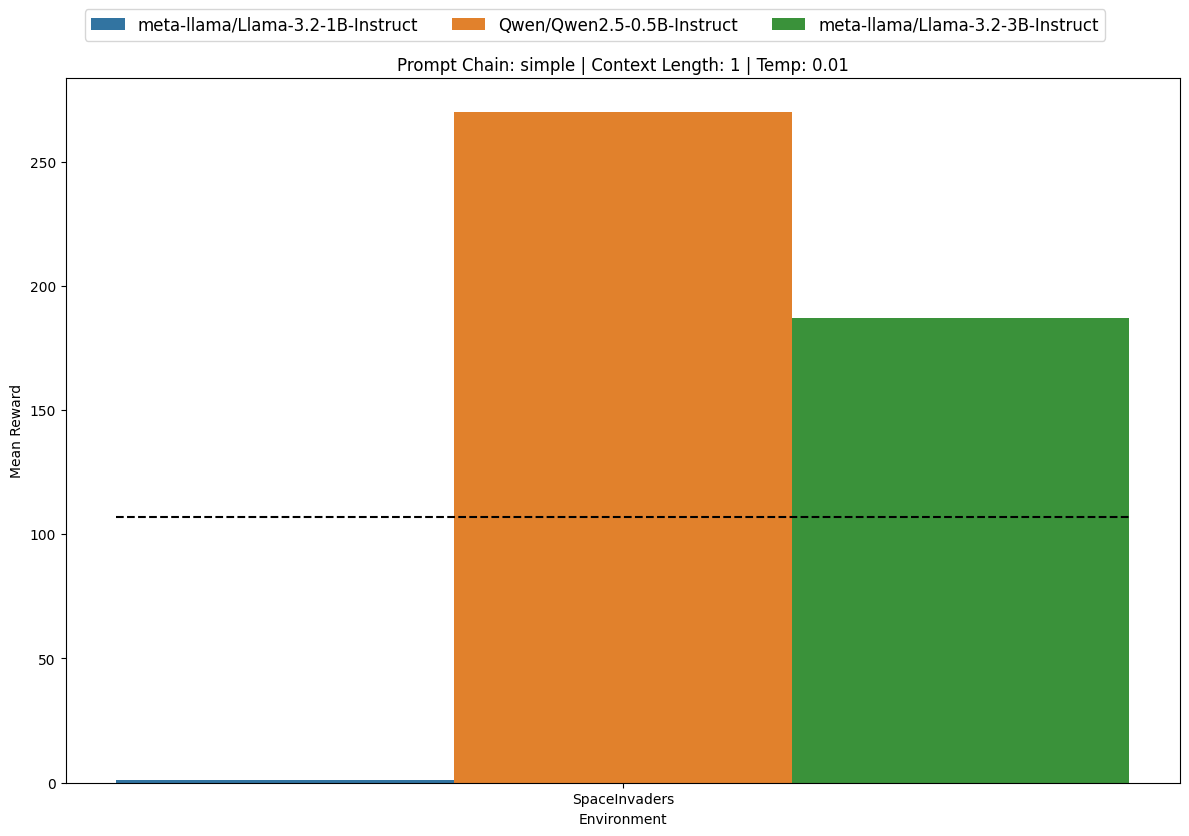

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a color palette based on unique model names
unique_models = df['model_name'].unique()
palette = dict(zip(unique_models, sns.color_palette("tab10", len(unique_models))))

# Get unique values
unique_prompt_chains = df['prompt_chain'].unique()
unique_context_lengths = df['context_length'].unique()
unique_temperatures = df['temperature'].unique()

for temp in unique_temperatures:
    df_temp = df[df['temperature'] == temp]
    
    for context_len in unique_context_lengths:
        df_context = df_temp[df_temp['context_length'] == context_len]
        
        fig, axs = plt.subplots(1, len(unique_prompt_chains), figsize=(12, 8), sharey=True)
        
        if not isinstance(axs, np.ndarray):
            axs = [axs]
        
        for i, prompt_chain in enumerate(unique_prompt_chains):
            df_ = df_context[df_context['prompt_chain'] == prompt_chain]
            df_['mean_reward'] = df_['mean_reward'].replace(0, 1)
            
            ax = axs[i]
            sns.barplot(x='env_id', y='mean_reward', data=df_, hue='model_name', ax=ax, palette=palette)
            ax.set_title(f"Prompt Chain: {prompt_chain} | Context Length: {context_len} | Temp: {temp}")
            ax.set_ylabel('Mean Reward')
            ax.set_xlabel('Environment')
            
            # Loop over each x-tick (environment) and add a dashed horizontal line for the random agent baseline.
            xticks = ax.get_xticks()
            xticklabels = ax.get_xticklabels()
            for tick, label in zip(xticks, xticklabels):
                env = label.get_text()
                # Filter random_agent_df by the current environment.
                baseline_val = random_agent_df[random_agent_df['env_id'] == env]['mean_reward'].mean()
                # Draw a dashed line centered on the tick (assuming a bar width of ~0.8)
                ax.hlines(y=baseline_val, xmin=tick - 0.4, xmax=tick + 0.4, colors='black', linestyles='dashed')
            
            # Remove individual subplot legends
            try:
                ax.legend_.remove()
            except Exception:
                pass
        
        # Create a single shared legend
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', ncol=len(unique_models), bbox_to_anchor=(0.5, 1.05), fontsize='large')
        
        plt.tight_layout()
        plt.show()
